>Я знайшов дуже схожий дата сет, що був в 3 домашній роботі. Однакові колонки, але з іншими значеннями.
Головне завдання полягає в передбаченні ціни на будинок(SalePrice) на основі різних характеристик будинків.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
%matplotlib inline

In [3]:
# Desciption
with open('Ames_Housing_Feature_Description.txt','r') as f: 
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [4]:
df = pd.read_csv('data_house.csv')

In [5]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 1. Працюємо з вибросами

In [6]:
df.corr()['SalePrice'].sort_values() # подивимось у якої ознаки найбільша кореляція

PID               -0.246521
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Overall Cond      -0.101697
MS SubClass       -0.085092
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Yr Sold           -0.030569
Misc Val          -0.015691
BsmtFin SF 2       0.005891
3Ssn Porch         0.032225
Mo Sold            0.035259
Pool Area          0.068403
Screen Porch       0.112151
Bedroom AbvGr      0.143913
Bsmt Unf SF        0.182855
Lot Area           0.266549
2nd Flr SF         0.269373
Bsmt Full Bath     0.276050
Half Bath          0.285056
Open Porch SF      0.312951
Wood Deck SF       0.327143
Lot Frontage       0.357318
BsmtFin SF 1       0.432914
Fireplaces         0.474558
TotRms AbvGrd      0.495474
Mas Vnr Area       0.508285
Garage Yr Blt      0.526965
Year Remod/Add     0.532974
Full Bath          0.545604
Year Built         0.558426
1st Flr SF         0.621676
Total Bsmt SF      0.632280
Garage Area        0.640401
Garage Cars        0.647877
Gr Liv Area        0

>Це ознаки Overall Qual та Gr Liv Area. Нарисуємо для них графіки scatterplot.

<AxesSubplot:xlabel='Overall Qual', ylabel='SalePrice'>

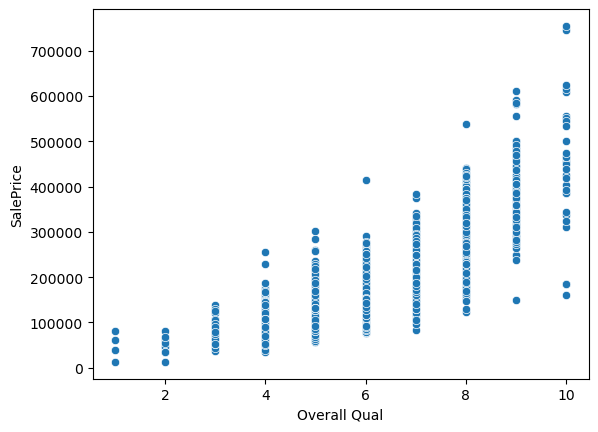

In [7]:
sns.scatterplot(x='Overall Qual',y='SalePrice',data=df)

>З графіка бачимо лінійну залежність, тобто зі збільшенням Overall Qual, збільшується SalePrice. Але є точки в яких Overall Qual > 8, але SalePrice < 200000. Ці точки можливо є вибросами.

In [8]:
df[(df['Overall Qual']>8) & (df['SalePrice']<200000)]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1182,533350090,60,RL,NaN,24572,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Family,150000
1498,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
2181,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


>Бачимо що є 4 точки. Давайте побудуємо графік з ознакою Gr Liv Area.

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

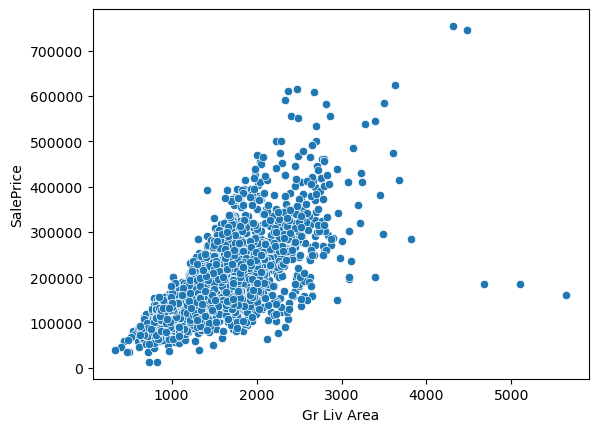

In [9]:
sns.scatterplot(x='Gr Liv Area',y='SalePrice',data=df)

>На цьому графіку бачимо точки, де 'Gr Liv Area' > 4000 та 'SalePrice' < 200000, це нелінійна залежність. Точки, де SalePrice > 700000 на мою думку це не є вибросами, тому що це лінійна залежність і ці дома можливо найякісніші і їхня Overall Qual могла би бути більше ніж 10, якщо це було б можливо.

In [10]:
df[(df['Gr Liv Area']>4000) & (df['SalePrice']<400000)]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
2181,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [11]:
df[(df['Overall Qual']>8) & (df['SalePrice']<200000)].index

Int64Index([1182, 1498, 2180, 2181], dtype='int64')

In [12]:
df[(df['Gr Liv Area']>4000) & (df['SalePrice']<400000)].index

Int64Index([1498, 2180, 2181], dtype='int64')

>Якщо порівняти індекси точок, які ми знайшли за допомогою цих двох ознак, то виявляється що три точки мають однакові індекси. Це є виброси. Тому ми їх можемо видалити.

In [13]:
ind_drop = df[(df['Gr Liv Area']>4000) & (df['SalePrice']<400000)].index

In [14]:
df = df.drop(ind_drop,axis=0)

>Подивимось на наш нові дані

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

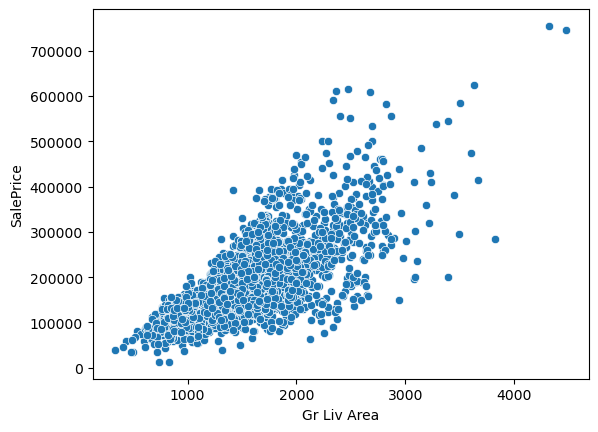

In [15]:
sns.scatterplot(x='Gr Liv Area',y='SalePrice',data=df)

>Як бачимо, виброси зникли.

## 2. Працюємо з пропущеними значеннями.

### Видалення колонки PID

>У нас вже є індекс тому для роботи регресії нам не потрібен унікальний ідентифікатор

In [16]:
df = df.drop('PID',axis=1)

### Ознаки зі значенням NaN

In [17]:
# вибираємо тільки колонки з пропущеними значеннями
cols_with_missing = df.isna().any()

# виводимо колонки та кількість їхніх пропущених значень
df.loc[:, cols_with_missing].isna().sum()

Lot Frontage       490
Alley             2729
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2915
Fence             2355
Misc Feature      2822
dtype: int64

>Зробимо функцію, яка рахує у відсотках кількість пропущених значень в колонці.

In [18]:
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

In [19]:
percent_nan = percent_missing(df)

>Побудуємо barplot за зростанням кількості пропущених значень в колонці.

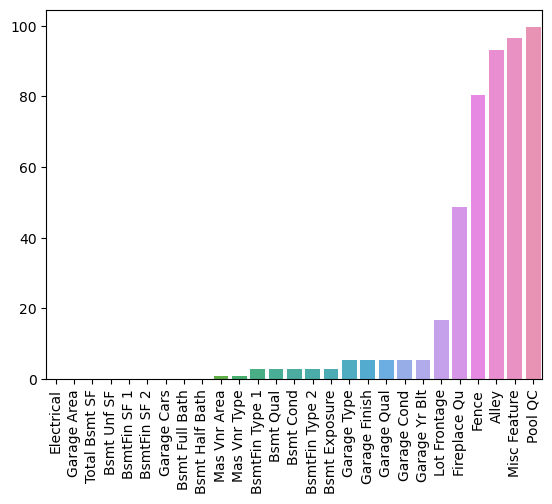

In [20]:
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

>Тепер потрібно зрозуміти чи замінити пропущені значення чи видалити їх. Спочатку попрацюємо з рядками. Давайте виберемо порогове значення та скажемо, що при його перебільшенні будемо видаляти рядки. Нехай порогове значення буде 1%. Якщо менше 1% рядків містять невизначене значення якоїсь ознаки, то тоді ми замінимо відсутні дані або їх видалимо.

### Робота з рядками 

(0.0, 1.0)

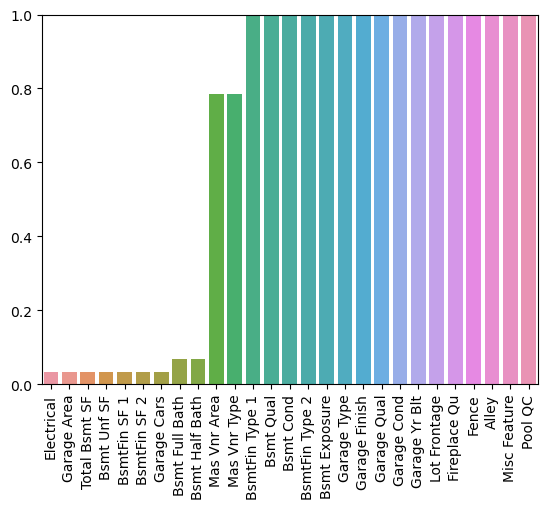

In [21]:
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

# Встановлюємо порогове значення 1% 
plt.ylim(0,1)

In [22]:
percent_nan[percent_nan < 1]  # Порівнюємо з пороговим значенням.

Electrical        0.034165
Garage Area       0.034165
Total Bsmt SF     0.034165
Bsmt Unf SF       0.034165
BsmtFin SF 1      0.034165
BsmtFin SF 2      0.034165
Garage Cars       0.034165
Bsmt Full Bath    0.068329
Bsmt Half Bath    0.068329
Mas Vnr Area      0.785787
Mas Vnr Type      0.785787
dtype: float64

In [23]:
100/len(df)

0.0341646737273659

Якщо 100 поділити на довжину датафрейму, то це одне значення у відсотках. Як можна побачити вище, такі колонки, як: Electrical, Garage Area, Total Bsmt SF і т.д мають тільки одне пропущене значення.

Це просто такий невеликий цікавий аналіз:)

In [24]:
df[df['Total Bsmt SF'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1341,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,...,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml,79000


Як бачимо так і є, колонка Total Bsmt SF має тільки одне відсутнє значення.

Ми маємо багато ознак для basement. Є 2 типи цих ознак - числові та текстові. Числові заповнимо нулями, а текстові - стрічкою 'None'.

In [25]:
bsmt_num_cols = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
df[bsmt_num_cols] = df[bsmt_num_cols].fillna(0)

In [26]:
bsmt_str_cols =  ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
df[bsmt_str_cols] = df[bsmt_str_cols].fillna('None')

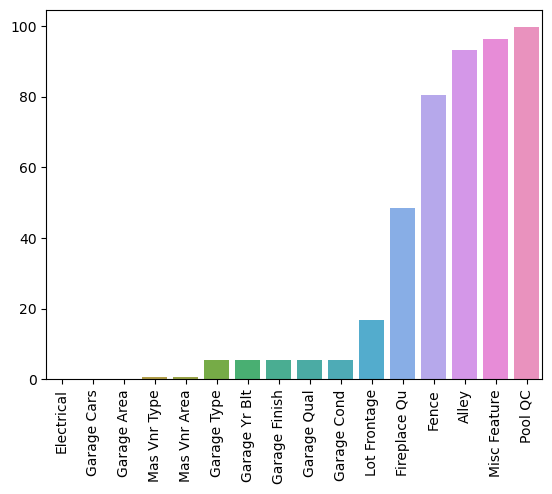

In [27]:
percent_nan = percent_missing(df)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

Колонки Electrical, Garage Cars та Garage Area, ми також могли заповнити пропущені дані якимись значеннями, але для прикладу давайте їх просто видалимо.

In [28]:
df[df['Garage Area'].isnull()].index[0], df[df['Garage Cars'].isnull()].index[0]

(2236, 2236)

Колонки Garage Area та Garage Cars мають однаковий індекс, тобто один рядок має два пропущених значення і при видаленні можна взяти тільки одну колонку.
Це також просто дослідження.

In [29]:
df = df.dropna(axis=0, subset=['Electrical', 'Garage Cars'])

Знову подивимось на графік.

(0.0, 1.0)

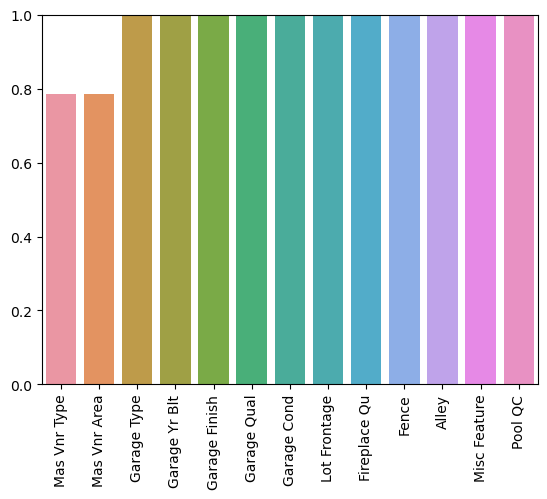

In [30]:
percent_nan = percent_missing(df)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.ylim(0,1)

>Як бачимо з графіка, залишились 2 колонки, які мають менше 1 відсотку пропущених значень.
Це ознаки Mas Vnr Type та Mas Vnr Area. Відсутність даних в цих ознаках найімовірніше означає, 
що будинок не має облицювання кам`яною плиткою, і в цьому разі ми зазначимо нульове 
значення, як ми робили раніше для інших ознак. 

In [31]:
df["Mas Vnr Type"] = df["Mas Vnr Type"].fillna("None")
df["Mas Vnr Area"] = df["Mas Vnr Area"].fillna(0)

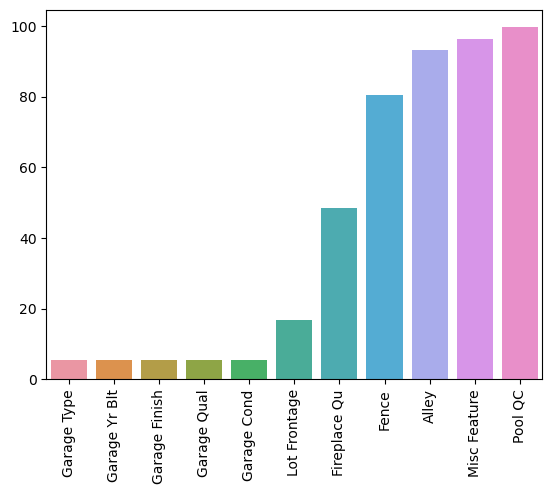

In [32]:
percent_nan = percent_missing(df)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

### Робота з колонками

Колонки Garage 

In [33]:
df[['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']]

,Garage Type,Garage Finish,Garage Qual,Garage Cond
0,Attchd,Fin,TA,TA
1,Attchd,Unf,TA,TA
2,Attchd,Unf,TA,TA
3,Attchd,Fin,TA,TA
4,Attchd,Fin,TA,TA
...,...,...,...,...
2925,Detchd,Unf,TA,TA
2926,Attchd,Unf,TA,TA
2927,NaN,NaN,NaN,NaN
2928,Attchd,RFn,TA,TA


Рядок 2927 та інші мають значення NaN. Судячи з опису даних, значення NaN означає відсутність гаража, тому ми запишемо значення "None" або 0.

In [34]:
gar_str_cols = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
df[gar_str_cols] = df[gar_str_cols].fillna('None')

In [35]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)

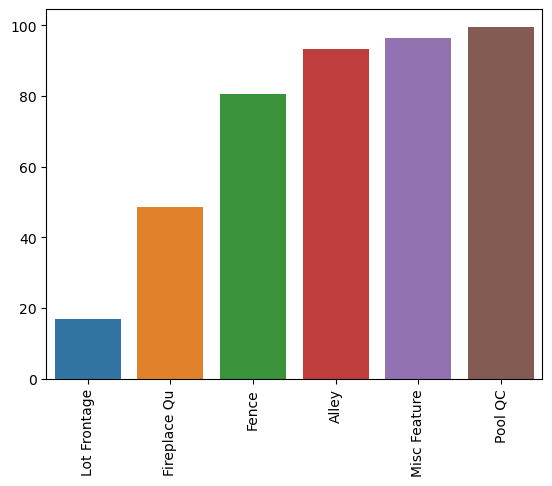

In [36]:
percent_nan = percent_missing(df)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

In [37]:
percent_nan

Lot Frontage    16.752137
Fireplace Qu    48.547009
Fence           80.478632
Alley           93.230769
Misc Feature    96.410256
Pool QC         99.589744
dtype: float64

>Якщо значення відсутні в досить великій кількості рядків, то має сенс видалити такі колонки повністю.
Давайте для нашого прикладу видалимо колонки з більш ніж 80 відсотків пропущених значень  

In [38]:
df = df.drop(['Pool QC','Misc Feature','Alley','Fence'],axis=1)

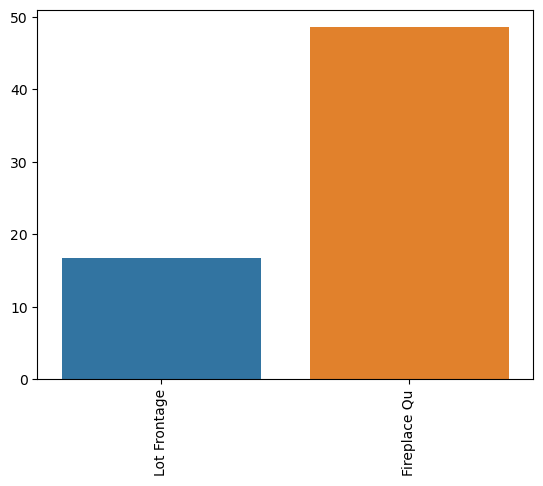

In [39]:
percent_nan = percent_missing(df)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

Залишилось дві колонки. Їх не можна видаляти, тому що ми знаходимось в середині діапазону. Давайте детальніше подивимось на ці колонки

In [40]:
df['Fireplace Qu'].value_counts()

Gd    741
TA    600
Fa     75
Po     46
Ex     43
Name: Fireplace Qu, dtype: int64

Ми бачимо 5 текстових значень, тобто це текстова колонка. Замінимо пропущені значення на None.

In [41]:
df['Fireplace Qu'] = df['Fireplace Qu'].fillna("None")

In [42]:
df['Lot Frontage']

0       141.0
1        80.0
2        81.0
3        93.0
4        74.0
        ...  
2925     37.0
2926      NaN
2927     62.0
2928     77.0
2929     74.0
Name: Lot Frontage, Length: 2925, dtype: float64

>Колонка Lot Frontage(довжина фасаду земельної ділянки, яка розташована вздовж дороги) - це числова колонка. Замінити пропущені значення нулями буде не коректно. Тому ми можемо спробувати обчислити середнє значення цієї ознаки на основі іншої ознаки. І в якості іншої колонки ми можемо взяти Neighborhood(окремі райони).
Тобто наша логіка буде наступною, якщо значення LotFrontage=NaN:
>1) Ми візьмемо для такого будинку значення Neighborhood
2) Далі для цього Neighborhood обчислимо середнє значення колонки LotFrontage для всіх будинків цього Neighborhood
3) І це середнє значення візьмемо в якості LotFrontage для нашого будинку.

Побудуємо графік boxplot і побачимо чи корелює LotFrontage з ознакою Neighborhood

<AxesSubplot:xlabel='Lot Frontage', ylabel='Neighborhood'>

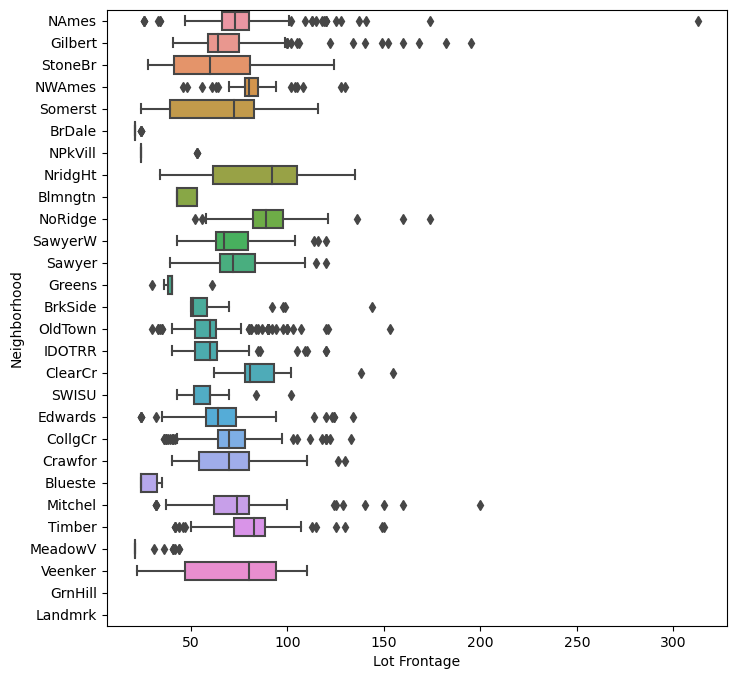

In [43]:
plt.figure(figsize=(8, 8))
sns.boxplot(x='Lot Frontage',y='Neighborhood',data=df,orient='h')

>З графіка видно, що для деяких районів є достатньо велика кількість викидів, але ми можемо припустити що існує зв'язок між районом міста і середнім значенням ознаки LotFrontage 

In [44]:
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(\
                                  lambda value: value.fillna(value.mean()))

In [45]:
df['Lot Frontage'].isna().sum()

3

>transform дозволяє об'єднати groupby з apply. У нас залишилось 3 будинки, які все ще мають значення NaN. Це сталося через те, що в деяких Neighborhood всі будинки мають невизначені значення LotFrontage. І тому для них можемо замінити пропущені значення на нулі.

In [46]:
df['Lot Frontage'] = df['Lot Frontage'].fillna(0)

In [47]:
percent_nan = percent_missing(df)
percent_nan

Series([], dtype: float64)

In [48]:
df.isna().sum()

MS SubClass       0
MS Zoning         0
Lot Frontage      0
Lot Area          0
Street            0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 76, dtype: int64

## 3. Працюємо з категоріальними даними 

Під час переведення категоріальних значень у числові значення потрібно бути обережними і стежити за тим, що числові зв'язки мають сенс для моделі. Наприклад, числа в колонці MSSubClass - це просто деякий код для кожного класу:

    MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Тут кожне число не пов'язане з іншими числами в цій же колонці. Наприклад, 30 > 20, однак це не означає, що значення "1-STORY 1945 & OLDER" у якомусь сенсі більше за значення "1-STORY 1946 & NEWER ALL STYLES". Хоча в інших випадках, наприклад, в колонці Overall Quality 10 > 5 і це вже має сенс, бо чим якісніше будинок, тим вища оцінка. Тобто Overall Quality це ординальна змінна, а MSSubClass це номінальна змінна. Таким чином MSSubClass нам треба перетворити в текстові значення, а Overall Quality ні.

    OverallQual: Rates the overall material and finish of the house

        10    Very Excellent
         9	Excellent
         8	Very Good
         7	Good
         6	Above Average
         5	Average
         4	Below Average
         3	Fair
         2	Poor
         1	Very Poor

In [49]:
# Конвертація в строку (це треба для того, щоб перевести кожне значення MS SubClass в dummy змінні)
df['MS SubClass'] = df['MS SubClass'].apply(str) 

Тепер розділимо наш датафрейм на текстові та числові колонки.

In [50]:
my_obj_df = df.select_dtypes(include='object')

In [51]:
my_num_df = df.select_dtypes(exclude='object')

Для текстових колонок створюємо dummy змінні

In [52]:
# drop_first=True для видалення дублікату.
df_obj_dummies = pd.get_dummies(my_obj_df, drop_first=True)

>І НАРЕШТІ СТВОРИМО НАШ ФІНАЛЬНИЙ ДАТАФРЕЙМ!!!

In [53]:
df = pd.concat([my_num_df, df_obj_dummies], axis=1)

In [54]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,1,0,0,0,1,0
2,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,1,0,0,0,1,0
3,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,...,0,0,0,0,1,0,0,0,1,0
4,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,1,0,0,0,1,0


## Оцінка моделі

#### Визначаємо метрики якості результатів моделі з допомогою LinearRegression

Розділимо дані на дві частини - ознаки X і цільова змінна y.

In [55]:
X = df.drop('SalePrice', axis=1)

In [56]:
y = df['SalePrice']

Розділимо X та y на train і validation(other) підвиборки у співвідношенні 70/30.

In [57]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=42)

Розділимо X_other та y_other на validation та test підвиборки у співвідношенні 50/50. В результаті для train підвиборки 70%, для validation та test по 15%. 

In [58]:
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

Робимо масштабування ознак

In [59]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Створюємо допоміжну функцію для запуску моделей.

In [60]:
def run_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    
    model.fit(X_train, y_train) # навчання моделі
    
    train_pred = model.predict(X_train) # прогнозування
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    train = np.sqrt(mean_squared_error(y_train, train_pred)) # обчислення rmse
    val = np.sqrt(mean_squared_error(y_val, val_pred))
    test = np.sqrt(mean_squared_error(y_test, test_pred))
    
    print(f'train rmse: {np.round(train, 5)}') # вивід метрик
    print(f'valid rmse: {np.round(val, 5)}')
    print(f'test  rmse: {np.round(test, 5)}')

Створимо просту модель лінійної регресії з параметрами по замовчуванню.

In [61]:
model = LinearRegression()

In [62]:
run_model(model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 19380.62059
valid rmse: 153142743302795.12
test  rmse: 79202946267849.9


In [63]:
np.mean(df['SalePrice'])

180815.53743589742

>         Порівнюючи RMSE на навчальному наборі даних з середнім значенням ціни на будинки, наша модель помиляється приблизно на 10 відсотків, що є непогано. Але RMSE на валідаційному і тестовому наборах даних є дуже високою. Це є перенавчання. 
>         Отже, реалізуємо крос-валідацію для пошуку оптимальних гіперпараметрів і візьмемо ElasticNet регуляризацію для зменшення ваг моделі та зниження ризику перенавчання.

Спочатку подивимось які метрики видасть базова модель ElasticNet()

In [64]:
base_elastic_model = ElasticNet()
run_model(base_elastic_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 46247.61226
valid rmse: 48441.49324
test  rmse: 41320.24952


>Бачимо, що метрики майже збігаються, тому перенавчання немає. Але модель помиляється приблизно на 25 відсотків. Виконаємо пошук оптимальних гіперпараметрів за сіткою.

In [65]:
param_grid = {'alpha':[0.1, 1, 5, 10, 50, 100],
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

grid_model = GridSearchCV(base_elastic_model, param_grid)
run_model(grid_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 19696.15964
valid rmse: 22829.35481
test  rmse: 19392.43029


In [66]:
grid_model.best_params_

{'alpha': 10, 'l1_ratio': 1}

>Бачимо, що метрики в два рази стали меншими і наша модель помиляється на всіх метриках приблизно на 10 відсотків, тобто нам вдалося покращити нашу модель!

#### І додатково подивимось на інші моделі, але вже без крос-валідації.

In [67]:
# Поліноміальна регресія 
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
run_model(poly_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 65.21747
valid rmse: 63191390518688.24
test  rmse: 57523548980871.31


In [68]:
# Дерева рішень
tree_model = DecisionTreeRegressor()
run_model(tree_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 62.51526
valid rmse: 32524.994
test  rmse: 29613.1804


In [69]:
# Випадкові ліса
forest_model = RandomForestRegressor()
run_model(forest_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 9642.4136
valid rmse: 25388.1184
test  rmse: 19817.2286


In [70]:
# Адаптивний бустінг
ada_model = AdaBoostRegressor()
run_model(ada_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 28930.18645
valid rmse: 30875.93981
test  rmse: 29718.65904


In [71]:
# Градієнтний бустінг
gradient_model = GradientBoostingRegressor()
run_model(gradient_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

train rmse: 15027.55593
valid rmse: 21548.1568
test  rmse: 17773.1476


## Висновок

    Я вибрав метрику RMSE, тому що вона вимірюється в тих же одиницях, що й цільова зміна на відміну від MSE.
    1) Спочатку я спробував лінійну регресію з параметрами по замовчуванню і в результаті виявили перенавчання, тому ця модель нам не підходить.
    2) Через перенавчання я взяв L1, L2 регуляризацію для того, щоб вибрати оптимальні гіперпараметри.
    3) Базова модель ElasticNet з параметрами по замовчуванню показує майже однакові значення для наборів даних і тому перенавчання немає, але показує відносно не дуже добрі результати.
    4) Тому наступним кроком за допомогою GridSearchCV знайдемо оптимальні гіперпараметри. І в результаті бачимо значне покращення моделі.
    5) Спробуємо інші моделі. Поліноміальна регресія має також перенавчання, як і лінійна регресія. 
    6) Дерева рішень показують досить непоганий результат. Модель майже не помиляється на навчальному наборі. На валідаційному та тестовому показують непоганий результат(17 відсотків помилка). Різниця між навчальним та тестовим набором даних досить велика, але якщо порівняти з поліноміальною регресією(ці моделі мають майже однакове значення для train rmse), то valid та test rmse набагато менше у моделі дерева рішень. Тому, на мою думку, це не перенавчання.
    7) І для того, щоб покращити результати для дерев рішень ми можемо використати випадкові ліса - сукупність(ансамблі) дерев рішень. І вже вони нам видали дуже хороші результати(дуже схожі з ElasticNet).
    8) Щодо бустингу. Адаптивний показує непогані результати, cхожі до дерева рішень, але train підвибірка на відміну від дерева рішень майже збігається з valid та test. Градієнтний показує дуже хороші результати, такі як в ElasticNet та RandomForest.
    Отже, можна дійти висновку, що для нашого датасету найкращими моделями виявились ElasticNet, знайдена в результаті пошуку гіперпараметрів, RandomForest та GradientBoostingRegressor.